# Preprocessing

In [1]:
import re
import os
import glob
import html
import shutil

import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
LACUNA = re.compile(r'\.\.+')

def load_file(path):
    with open(path) as f:
        xml_text = f.read()
    
    xml_text = xml_text.replace('&oudpond;', '')
    xml_text = xml_text.replace('&supm;', 'm')
    xml_text = xml_text.replace('&supM;', 'm')
    xml_text = xml_text.replace('&supc;', 'c')
    xml_text = xml_text.replace('&supt;', 't')
    xml_text = xml_text.replace('&supn;', 'n')
    xml_text = xml_text.replace('&sups;', 's')
    xml_text = xml_text.replace('&supd;', 'd')
    xml_text = xml_text.replace('&supc;', 'c')
    xml_text = xml_text.replace('&uring;', 'u')
    xml_text = xml_text.replace('&lt;', '')
    xml_text = xml_text.replace('&gt;', '')
    xml_text = html.unescape(xml_text)

    soup = BeautifulSoup(xml_text)
    
    data = {}

    # extract metadata:
    data['id'] = os.path.basename(path).replace('.xml', '')
    data['title'] = soup.find('title').text
    data['author'] = soup.find('author').text
    
    postquem = '<UNK>'
    try:
        postquem = soup.find('interpgrp', {'type': 'witnessYear_from'})
        postquem = postquem.find('interp')['value']
    except AttributeError:
        pass
    
    antequem = '<UNK>'
    try:
        antequem = soup.find('interpgrp', {'type': 'witnessYear_to'})
        antequem = antequem.find('interp')['value']
    except AttributeError:
        pass
    
    data['date'] = f'{postquem}-{antequem}'
    
    provenance = '<UNK>'
    try:
        provenance = soup.find('interpgrp', {'type': 'corpusProvenance'})
        provenance = provenance.find('interp')['value']
    except AttributeError:
        pass
    data['provenance'] = provenance
    
    # extract and clean lines:
    lines = []
    for line in soup.find_all('l'):
        text = line.get_text().strip()
        if text and not re.search(LACUNA, text):
            line = ''.join([c for c in text if c.isalpha() or c.isspace()]).strip()
            if line:
                lines.append(line)
    
    data['lines'] = lines
    
    return data

In [3]:
texts = []
for fn in tqdm(glob.glob('../data/cdrom_rhyme/*.xml')):
    texts.append(load_file(fn))

100%|██████████| 262/262 [00:36<00:00,  7.23it/s]


In [4]:
for fn in tqdm(glob.glob('../data/cdrom_CG1/*.xml')):
    with open(fn) as f:
        text = f.read()
    
    # metadata
    data = {}
    data['id'] = os.path.basename(fn).replace('.xml', '')
    data['title'] = re.findall(r'\<bron_oms\>(.*)\<\/bron_oms\>', text)[0]
    postquem = re.findall(r"jaar\_tot\=\'([0-9]+)'", text)[0]
    antequem = re.findall(r"jaar\_van\=\'([0-9]+)'", text)[0]
    data['date'] = f'{postquem}-{antequem}'
    
    data['provenance'] = 'CG1'
    data['author'] = 'Onbekend'
    
    lines = []
    for line in text.split('\n'):
        line = line.strip()
        if not line:
            continue
        line = line.replace('<A >', '').replace('</A>', '')
        if not line or re.search(LACUNA, line):
            continue
        
        clean = ''
        for word in re.findall(r'<C ([0-9#\*@\+]+)_([^>]+)>\s*([^ \n\t\r<]+)', line):
            word = word[-1]
            word = ''.join([c for c in word if c.isalpha() or c.isspace()]).strip()
            if word:
                clean += word + ' '
        clean = clean.strip()
        if clean:
            lines.append(clean)
    
    data['lines'] = lines
    
    texts.append(data)

100%|██████████| 21/21 [00:01<00:00, 20.61it/s]


In [5]:
metadata = []
for text in texts:
    d = {d:text[d] for d in text if d != 'lines'}
    metadata.append(d)

In [6]:
mdf = pd.DataFrame(metadata)
mdf = mdf.set_index('id')
mdf

,title,author,date,provenance
id,,,,
ongeidentificeerd_6,Ongeïdentificeerd (6),Onbekend,1375-1400,cdrom-mnl
theophilus,Theophilus,Onbekend,1400-1420,cdrom-mnl
madelgijs_fragm_le2,Madelgijs,Onbekend,1350-1400,cdrom-mnl
roelantslied_fragm_br,Roelantslied,Onbekend,1350-1400,cdrom-mnl
spiegel_der_jongers,Spiegel der jongers,Lambertus Goetman,1510-1520,cdrom-mnl
...,...,...,...,...
"Der naturen bloeme, handschrift M","Der naturen bloeme, handschrift M",Onbekend,1300-1276,CG1
Aiol,Aiol,Onbekend,1240-1220,CG1
Enaamse Codex,Enaamse Codex,Onbekend,1290-1290,CG1


Clean up author labels:

In [7]:
import numpy as np
mdf['author'] = mdf['author'].replace('Niet van toepassing', 'Onbekend')
mdf['author'] = mdf['author'].replace('Onbekend', np.nan)
mdf['author'] = mdf['author'].str.replace(r'Jacob van Maerlant\?', 'Jacob van Maerlant(?)')
mdf['author'].value_counts(dropna=True)

Lodewijk van Velthem          16
Jacob van Maerlant            15
Philip Utenbroeke              8
Jan van Boendale               6
Jacob van Maerlant(?)          4
Augustijnken                   3
Hadewijch                      2
Jan de Weert                   2
Hein van Aken                  2
Willem van Hildegaersberch     1
Hein van Aken(?)               1
Heinriic                       1
Willem                         1
Dirc Potter                    1
Clays van Haerlem              1
Penninc en Pieter Vostaert     1
Heraut Beyeren                 1
Diederic van Assenede          1
Loy Latewaert                  1
Gielijs van Molhem             1
Hendrik van Veldeke            1
Jan van Heelu                  1
Jan Praet                      1
Lambertus Goetman              1
Calfstaf en Noydekin(?)        1
Melis Stoke                    1
Name: author, dtype: int64

Set some (uninformative) values for missing dates:

In [8]:
mdf.loc['jan_splinters_testament', 'date'] = '1550-1550'
mdf.loc['borchgrave_van_couchi_fragm_dp', 'date'] = '1300-1325'
mdf.loc['grimbergse_oorlog', 'date'] = '1300-1350'

In [9]:
mdf['date_range'] = mdf['date']
dates = []
for d in mdf['date_range']:
    d1, d2 = [int(date_str) for date_str in d.split('-')]
    d = d1 + ((d2 - d1) / 2)
    dates.append(d)
mdf['date'] = dates

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

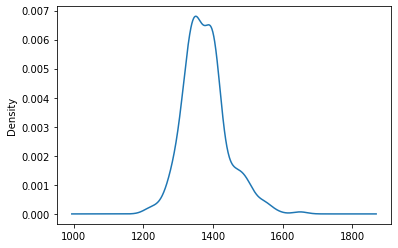

In [10]:
mdf['date'].plot.kde();

In [11]:
mdf['genre'] = None
mdf['subgenre'] = None
mdf.to_excel('../data/metadata_extract.xlsx', header=True, index=True)

## Enrich using PIE

Taken from the [PIE NLP Taggers documentation](https://github.com/hipster-philology/nlp-pie-taggers):

In [12]:
from typing import List
from pie_extended.cli.utils import get_tagger, get_model, download
import lxml.etree

In [13]:
do_download = False # set to True if necessary
if do_download:
    for dl in download("dum"):
        x = 1

In [14]:
xml_path = '../data/xml'
try:
    shutil.rmtree(xml_path)
except FileNotFoundError:
    pass
os.mkdir(xml_path)

In [15]:
from pie_extended.models.dum.imports import get_iterator_and_processor
from collections import defaultdict

iterator, processor = get_iterator_and_processor()
tagger = get_tagger('dum', batch_size=256, device="cpu", model_path=None)

for text in tqdm(texts):
    title = text['id']
    root = lxml.etree.Element('text')
    root.attrib['id'] = title
    
    lines: List[str] = [l.lower() for l in text['lines']]
    for nb, line in enumerate(lines):
        l_node = lxml.etree.Element('l')
        l_node.attrib['n'] = str(nb + 1)
        
        p = defaultdict(list)
        for w in tagger.tag_str(line, iterator=iterator, processor=processor):
            p['tokens'].append(w['form'])
            p['lemmas'].extend(w['lemma'].split('+'))
            p['pos'].extend(w['pos'].split('+'))
            
        for tag in ('tokens', 'lemmas', 'pos'):
            subnode = lxml.etree.Element(tag)
            subnode.text = ' '.join(p[tag])
            l_node.append(subnode)    
        
        root.append(l_node)
    
    with open(f'{xml_path}/{title}.xml', 'w') as f:
        f.write(lxml.etree.tostring(root, xml_declaration=True,
                                pretty_print=True, encoding='utf-8').decode())
    

2023-01-31 16:10:58,540 : Model /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/pie_extended/downloads/dum/lemma.tar was serialized with a previous version of `pie`. This might result in issues. Model commit is 050815e, whereas current `pie` commit is 9ce3e8f.
2023-01-31 16:10:58,955 : Model /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/pie_extended/downloads/dum/pos.tar was serialized with a previous version of `pie`. This might result in issues. Model commit is 050815e, whereas current `pie` commit is 9ce3e8f.
100%|██████████| 283/283 [21:20:16<00:00, 271.44s/it]     
